In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import zipfile

from google.colab import files
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_file = '/content/drive/My Drive/Makeup. Pixel Perfect Lips Segmentation..zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

['.config', 'drive', 'set-lipstick-original', 'sample_data']


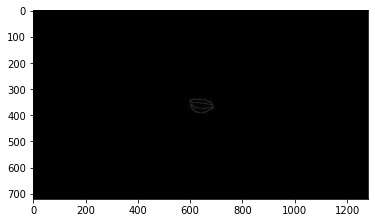

In [4]:
import matplotlib.pyplot as plt
img = plt.imread('set-lipstick-original/mask/mask00007052.png')
plt.imshow(img[..., 0], cmap='gray');

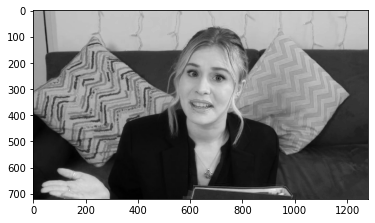

In [5]:
import matplotlib.pyplot as plt
img = plt.imread('set-lipstick-original/720p/image00007052.jpg')
plt.imshow(img[..., 0], cmap='gray');

In [6]:
DATA_ROOT = 'set-lipstick-original'
photo_directory = '/720p'
mask_directory = '/mask'
# cameraRGB = []
# cameraSeg = []

# for file in os.listdir(DATA_ROOT + photo_directory):
#     cameraRGB.append(DATA_ROOT + photo_directory + f'/{file}')
# for file in os.listdir(DATA_ROOT + mask_directory):
#     cameraSeg.append(DATA_ROOT + mask_directory + f'/{file}')
# cameraRGB.sort()
# cameraSeg.sort()

In [7]:
DATAFRAME_PATH = DATA_ROOT + '/list.csv'
data_frame = pd.read_csv(DATAFRAME_PATH)
print(f'Data shape {data_frame.shape}')
print(f'Images in folder - {len(os.listdir(DATA_ROOT + mask_directory))}\nMasks in folder - {len(os.listdir(DATA_ROOT + photo_directory))}')
data_frame.head()



Data shape (28594, 9)
Images in folder - 28540
Masks in folder - 28594


,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [8]:
for i in data_frame['mask']:
  if not os.path.exists(DATA_ROOT + mask_directory + f'/{i}'):
    data_frame['mask'] = data_frame['mask'].replace(i, np.NaN)


In [9]:
for i in data_frame['filename']:
  if not os.path.exists(DATA_ROOT + photo_directory + f'/{i}'):
    data_frame['mask'] = data_frame['filename'].replace(i, np.NaN)

In [10]:
data_frame.dropna(axis=0, inplace=True)
data_frame.shape

(28540, 9)

In [11]:
data_frame = data_frame[['filename', 'mask']]
data_frame['filename'] = DATA_ROOT + f"{photo_directory}/" + data_frame['filename']
data_frame['mask'] = DATA_ROOT + f'{mask_directory}/' + data_frame['mask']
data_frame

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,filename,mask
0,set-lipstick-original/720p/image00000001.jpg,set-lipstick-original/mask/mask00000001.png
1,set-lipstick-original/720p/image00000002.jpg,set-lipstick-original/mask/mask00000002.png
2,set-lipstick-original/720p/image00000003.jpg,set-lipstick-original/mask/mask00000003.png
3,set-lipstick-original/720p/image00000004.jpg,set-lipstick-original/mask/mask00000004.png
4,set-lipstick-original/720p/image00000005.jpg,set-lipstick-original/mask/mask00000005.png
...,...,...
28589,set-lipstick-original/720p/image00028590.jpg,set-lipstick-original/mask/mask00028590.png
28590,set-lipstick-original/720p/image00028591.jpg,set-lipstick-original/mask/mask00028591.png
28591,set-lipstick-original/720p/image00028592.jpg,set-lipstick-original/mask/mask00028592.png
28592,set-lipstick-original/720p/image00028593.jpg,set-lipstick-original/mask/mask00028593.png


In [12]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [13]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.image_arr = self.data.iloc[:,0]
        self.label_arr = self.data.iloc[:,1]
        self.data_len = len(self.data.index)
        self.preprocessing = preprocessing

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = np.asarray(img).astype('float')
    
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img) / 255.0

        img = img.permute(2,0,1)
        
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (256, 256))
        mask = np.asarray(mask).astype('float')
        mask = torch.as_tensor(mask) / 255.0
        mask = mask.permute(2,0,1)
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


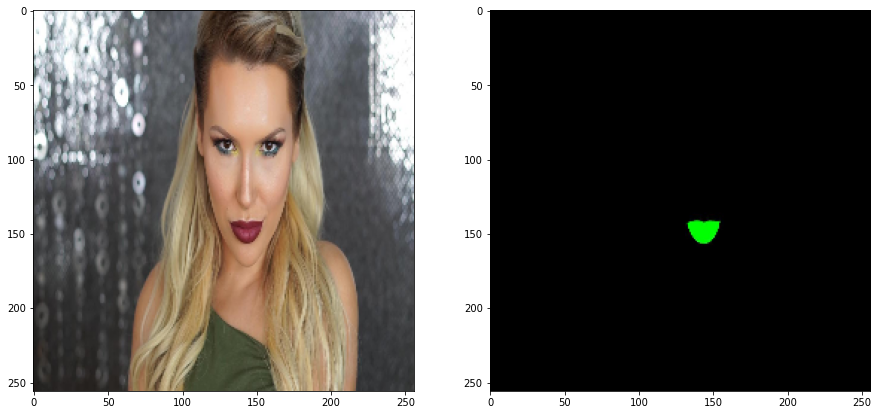

In [14]:
dataset = LipsDataset(data_frame)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0))
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data_frame, test_size=0.3)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train)
test_data = LipsDataset(X_test)

In [16]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

In [17]:
activation = torch.nn.Softmax(dim=1)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [19]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Linknet
BACKBONE = 'resnet50'
model = Linknet(encoder_name=BACKBONE, 
               encoder_weights='imagenet', 
               classes=1,
               activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [21]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    break

torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])
tensor(0.0235) tensor(1.)
tensor(0.) tensor(1.)


In [22]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [23]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [24]:
max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 2141/2141 [05:03<00:00,  7.05it/s, dice_loss - 0.0786, iou_score - 0.8623]
Model saved!


Очень долго разбирался со способами импортировать данные, в итоге получилось сделать с помощью гугл диска, что накладывает определенные особенности, но в итоге все получилось, на мой взгляд. 